# Homework 05 - Taming text

## Exercise 1 - Generating word clouds

### Step one - Using the raw corpus

In this part we will use the raw email contents with minimal pre-processing to generate a word cloud using the [word_cloud](https://github.com/amueller/word_cloud) library.

In [9]:
# Imports
import numpy as np
import pandas as pd
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
import re

%matplotlib inline

In [ ]:
# Uncomment and Run to download packages for nltk
# nltk.download()

First we load the email data, try to understand it's structure and choose which fields to use.

In [3]:
raw_emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


It seems that the `ExtractedBodyText` field is what we would like to work with. However there are some missing values. Let's see if there are many of them.

In [4]:
print('Number of emails with null ExtractedBodyText:', raw_emails['ExtractedBodyText'].isnull().sum())
print('Total number of emails:', len(raw_emails))

Number of emails with null ExtractedBodyText: 1203
Total number of emails: 7945


So we will not use this field. We will instead use `RawText` and do some minimal preprocessing on it to remove irrelevant parts.

In [5]:
def preprocess_raw_email(text):
    """Very simple email preprocessing that tries to remove
    email protocol metadata and standard headers"""
    
    keywords = ('U.S. Department of State', 'Department of State', 'Case No.',
                'Doc No.', 'STATE DEPT.', 'UNCLASSIFIED',
                'From:', 'To:', 'Sent:', 'Subject:', 'Attachments:',
                'Date:', 'Cc:')
    
    # Remove lines starting with keyword
    lines = text.split('\n')
    lines = [ l for l in lines if not l.startswith(keywords) ]
    
    return '\n'.join(lines)

In [17]:
def cloud(text): 
    """ Generate wordcloud """
    text = ' '.join(text) if type(text) != str else text
    wordcloud = wc(max_font_size=60).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## No NLP


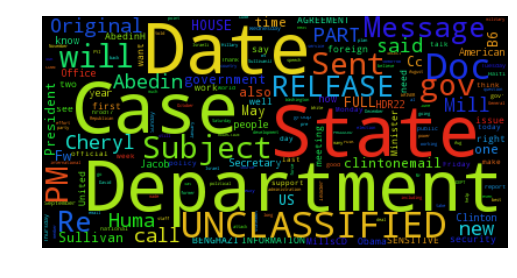

In [28]:
raw_text = raw_emails['RawText']
cloud(raw_text)

## Let's do some actual NLP

In [29]:
text = '\n'.join(raw_text.map(preprocess_raw_email)).strip().lower()

Tokenisation

In [12]:
tokenizer = RegexpTokenizer(r'\w+')
basic_tokens = tokenizer.tokenize(text)

Remove punctuations and numbers

In [21]:
# punctuation and numbers to be removed
punctuation = re.compile(r'[_\<\>\@\-\.\?!,":;()|0-9]')
single_letter = re.compile('^[a-z]$')
tokens = [punctuation.sub("", word) for word in basic_tokens]  
tokens = [single_letter.sub("", word) for word in tokens]  
tokens = filter(None, tokens)

Remove stopwords

In [24]:
my_stopwords = stopwords.words('english')
filtered_tokens = [ t for t in tokens if t not in my_stopwords]

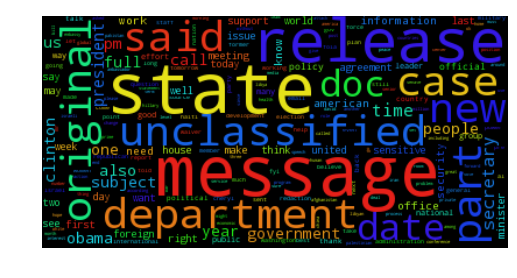

In [23]:
cloud(filtered_tokens)

TODO: we can do stemming, lemmatization and try to see if it is better